In [1]:
! source /scratch/qy775/nma/nmaenv/bin/activate

In [2]:
import os
import pickle
import nibabel as nib
from tqdm import tqdm
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import fdrcorrection

In [3]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_RDMs(rdms, metadata_labels):
    assert(len(rdms) == len(metadata_labels))
    num_rdms = len(rdms)
    fig, axes = plt.subplots(1, num_rdms, figsize=(15, 5))

    for i, (rdm, metadata_label) in enumerate(zip(rdms, metadata_labels)):
        rdm_rank = stats.rankdata(get_lowertriangular(rdm))
        rdm_rank_norm = rdm_rank / rdm_rank.max()
        rdm_rank_square = squareform(rdm_rank_norm)
        
        ax = axes[i] if num_rdms > 1 else axes  # Handle single subplot case
        im = ax.imshow(rdm_rank_square, cmap='jet')
        ax.set_title(f"{metadata_label} rank normalized RDM")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

def get_lowertriangular(rdm):
    num_conditions = rdm.shape[0]
    return rdm[np.triu_indices(num_conditions,1)]

def visualize_glass_brain(nii_save_path, visual_mask_3D, roi_path, savefig=None):
    brain_mask = os.path.join(roi_path,"groupMask_space-MNI152.nii")    
    saveasnii(brain_mask,nii_save_path,visual_mask_3D)
    if savefig:
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                         display_mode='lyrz',colorbar=True, vmax=0.34,
                         output_file= savefig)
    else:
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                         display_mode='lyrz',colorbar=True) 
    plt.show()

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [4]:
task='test'
radius = 4
dataset_root = "/scratch/qy775/nma/BOLDMomentsDataset"
save_root = f'/scratch/qy775/nma/results/{task}/metadata_rdm'
searchlight_root=os.path.join(dataset_root, "derivatives", "versionB", "MNI152","prepared_searchlight_pkl")

# Define the path for the new directory
plot_dir = os.path.join(save_root, "plots")

# Create the directory, including any intermediate directories
os.makedirs(plot_dir, exist_ok=True)

In [5]:
# Load Group Brain Mask
mask_root = os.path.join(dataset_root,'derivatives/versionB/MNI152/GLM/mask')

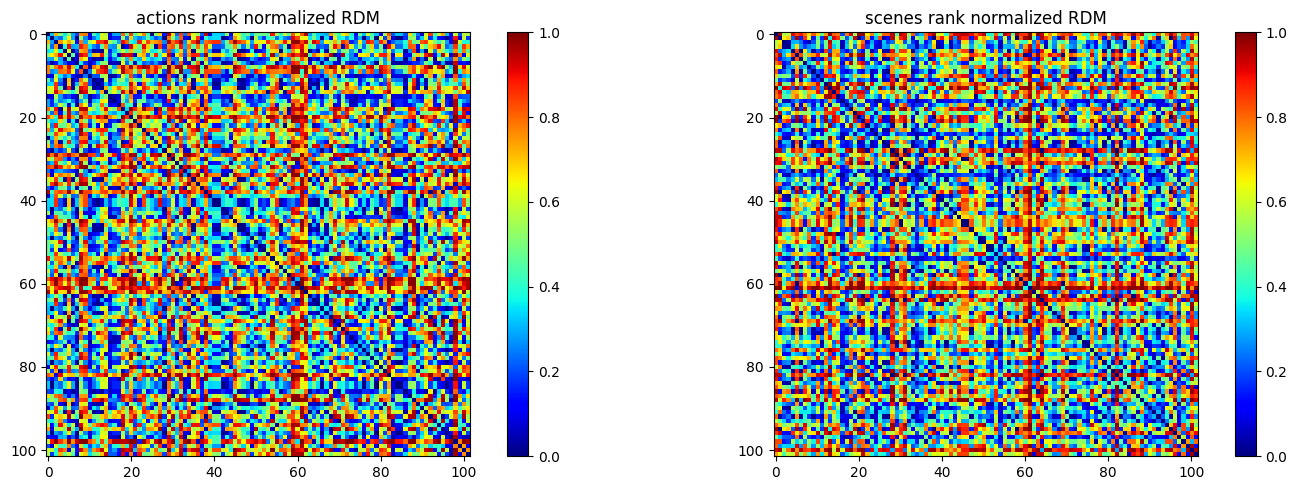

In [6]:
# temporarily use VersionA metadata since verB does not provide metadata RDMs
metadata_rdm_root = os.path.join(dataset_root,"derivatives","versionA","analysis","metadataRSA","rdms")

mlabels=["actions","scenes"] #["actions", "scenes", "objects", "ActionsObjectsScenes", "text_descriptions", 'GIT_image_caption']
meta_rdms = []
for metadata_label in mlabels: 
    meta = np.load(os.path.join(metadata_rdm_root, "MetadataRDM_humanAnnotated_label-" + metadata_label + "_task-" + task + "_metric-cosine.npy"))
    meta_rdms.append(meta)
    
visualize_RDMs(meta_rdms, mlabels)

In [11]:
# load prepared searchlight RDMs
#subjects = ['01','02','03','04','05','06','07','08','09','10']
subjects = ['01','02']

mlabels=["actions"] #["actions", "scenes", "objects", "ActionsObjectsScenes", "text_descriptions", 'GIT_image_caption']
meta_rdms = []
for metadata_label in mlabels: 
    for s, sub in enumerate(subjects):
        # load model RDM
        if metadata_label == 'GIT_image_caption':
            meta = np.load(os.path.join(metadata_rdm_root, "MetadataRDM_GITAnnotated_label-" + metadata_label + "_task-" + task + "_metric-cosine.npy"))
        else:
            meta = np.load(os.path.join(metadata_rdm_root, "MetadataRDM_humanAnnotated_label-" + metadata_label + "_task-" + task + "_metric-cosine.npy"))
    
        # load the prepared searchlight RDMs
        fname = f"sub-{sub}_searchlight-BetasAvg_task-{task}_corr-pearson_radius-{radius}.pkl"
        data = load_dict(os.path.join(searchlight_root, fname))
        search = data[0]
        image = data[1]
        dims = image.shape
        n_voxels = dims[0]*dims[1]*dims[2]
        print(n_voxels)
        
        #nan_indices = data[2
        nan_columns = []
        del data
    
        meta_ltrdm = get_lowertriangular(meta)
        corr = np.zeros((search.shape[1],))
        pval = np.zeros((search.shape[1],))
        
        for r in tqdm(range(search.shape[1])):
            # Check if the entire column search[:,r] is NaN
            if np.all(np.isnan(search[:,r])):
                nan_columns.append(r)
                continue  # Skip further processing for this column if it's all NaN
            
            tmp = stats.spearmanr(meta_ltrdm, search[:,r])
            corr[r] = tmp[0]
            pval[r] = tmp[1]

        # Log or process the indices that were all NaN if needed
        print(f"Subject {sub} had {len(nan_columns)} columns with all NaNs.")

        # FDR stats
        method = 'poscorr'
        fdr_tuple = fdrcorrection(pval, alpha = 0.05, method = method, is_sorted = False)
        
        corr_significant = corr * fdr_tuple[0]
        
        # Save RSA results
        fname = 'sub-'+sub + '_RSA-BetasAvg_task-' + task + '_corr-spearman_' + 'metadata-' + metadata_label + '_stats-FDR-q-0.05-method-' + method + '.pkl'
        with open(os.path.join(save_root, fname), 'wb') as fh:
            data = (corr, pval, fdr_tuple, nan_columns)
            pickle.dump(data, fh)

291214


100%|██████████| 291214/291214 [05:18<00:00, 914.21it/s] 


Subject 01 had 130696 columns with all NaNs.
291214


100%|██████████| 291214/291214 [05:21<00:00, 906.50it/s] 

Subject 02 had 130300 columns with all NaNs.


In [37]:
non_nan_num=291214-130696
non_nan_num

160518

## Normalize with ceiling and across subjects

Load Upper ceiling

In [9]:
subjects = ['01','02','03','04','05','06','07','08','09','10']

mlabels=["actions"] #["actions", "scenes", "objects", "ActionsObjectsScenes", "text_descriptions", 'GIT_image_caption']


In [17]:
#load the upper noise ceiling for noise normalization
fname = os.path.join(searchlight_root, f"noiseceiling-upper_searchlight-BetasAvg_task-{task}_radius-4.pkl")
with open(os.path.join(searchlight_root,fname),'rb') as fh:
    upper,mask_master = pickle.load(fh)
mask_data = mask_master.get_fdata()
#n_voxels = int(np.sum(mask_data > 0))
dims = mask_data.shape
n_voxels = dims[0]*dims[1]*dims[2]

zero_indices = np.where(mask_data==0)
zero_indices = np.ravel_multi_index(zero_indices, mask_data.shape)
non_zero_indices = np.where(mask_data>0)
non_zero_indices = np.ravel_multi_index(non_zero_indices, mask_data.shape)

In [103]:
mask_master.shape

(62, 77, 61)

In [ ]:
mask_data

In [91]:
n_voxels

291214

In [77]:
len(zero_indices)

184598

In [78]:
len(non_zero_indices)

106616

In [79]:
len(non_zero_indices)+len(zero_indices)

291214

In [35]:
int(np.sum(~np.isnan(mask_data)))

291214

In [34]:
mask_data.shape

(62, 77, 61)

In [18]:
#n_voxels = len(mask_master)
upper.shape 

(10, 106616)

In [31]:
len(nan_indices)

130696

In [42]:
nan_indices = np.array(nan_indices)  # Convert to NumPy array
valid_nan_indices = nan_indices[nan_indices < n_voxels].astype(int)
len(nan_indices)

130696

In [45]:
len(corr)

291214

In [84]:
common_indices = np.intersect1d(zero_indices, nan_indices)
print(len(common_indices)
common_indices

130696


array([     0,      1,      2, ..., 291211, 291212, 291213])

In [87]:
union_inval_indices = np.union1d(zero_indices, nan_indices)
print(len(union_inval_indices))
union_inval_indices

184598


array([     0,      1,      2, ..., 291211, 291212, 291213])

In [89]:
len(non_zero_indices)+len(zero_indices)-len(union_inval_indices)

106616

In [94]:
upper.shape

(10, 106616)

In [114]:
upper[:len(subjects),:].shape

(2, 106616)

In [108]:
corr_1D_all.shape

(2, 291214)

In [120]:
len(non_zero_indices == 1)

106616

In [16]:
np.ravel_multi_index(non_zero_indices, dims)

array([ 11069,  11128,  11129, ..., 274963, 275023, 279041])

In [ ]:
for metadata_label in mlabels:
    corr_1D_all = np.zeros((len(subjects), n_voxels))
    for s, sub in enumerate(subjects): #load all subject's searchlight-metadata correlations and store them in a 4D array
        print(sub)
        #load the subject's searchlight-metadata correlations
        fname =  f"sub-{sub}_RSA-BetasAvg_task-{task}_corr-spearman_metadata-{metadata_label}_stats-FDR-q-0.05-method-poscorr.pkl"
        with open(os.path.join(save_root, fname), 'rb') as fh:
            corr, _, _, nan_indices = pickle.load(fh) #(corr, pval, fdr_tuple, nan_indices)

        # Clip nan_indices to ensure they are within the range of n_voxels
        nan_indices = np.array(nan_indices)  # Convert to NumPy array
        union_inval_indices = np.union1d(zero_indices, nan_indices)
        
        #mask correlations by nans and add to the all subject array
        corr_1D = np.ones((n_voxels,))
        corr_1D[union_inval_indices] = 0
        corr_1D[corr_1D == 1] = corr[corr_1D == 1]
        corr_1D_all[s,:] = corr_1D

        del corr, nan_indices, corr_1D
        
    #Plot the glass brain of average RSA correlations per voxel masked by FDR significance
    #do ttest
    pval = np.zeros((n_voxels,))
    for vox in tqdm(range(n_voxels)): #performs a ttest at each voxel over the 10 subjects. Gets a p-value for each voxel. The null hypothesis is that the searchlight-metadata correlation is zero
        pval[vox] = stats.ttest_1samp(corr_1D_all[:,vox], popmean=0, alternative='two-sided')[1]

    #do FDR correction
    rejected, pval_corrected = fdrcorrection(pval[~np.isnan(pval)], alpha=0.05,  method='poscorr', is_sorted=False) #to address multiple comparisons, FDR correct over all voxels that are not nans (inside the brain)

    #plot average correlation masked by FDR significance
    #create significance mask from FDR
    pval_mask = np.ones((n_voxels,))
    pval_mask[np.isnan(pval)] = 0
    pval_mask[pval_mask==1] = rejected #1D array of 1's and 0's where 1 means that voxel survived FDR correction
    pval_mask_3D = pval_mask.reshape(dims) #reshape to a 3D matrix

    #manipulate the upper noise ceiling a bit to be compatible with our correlation matrix
    upper_1D_all = np.zeros((len(subjects),n_voxels))
    upper_1D_all[:,non_zero_indices] = upper[:len(subjects),:]
    upper_1D_all[:,zero_indices] = np.nan

    corr_1D_norm = corr_1D_all / upper_1D_all #normalizes each subject's searchlight-metadata correlations by their upper noise ceiling
    corr_1D_norm[:,zero_indices] = 0 #go back to changing nans to zeros
    corr_3D_norm = corr_1D_norm.reshape((len(subjects),dims[0],dims[1],dims[2])) #reshape these normalized values into 3D

    corr_3D_norm_avg = np.nanmean(corr_3D_norm, axis=0) #simply average the normalized values over the 10 subjects at each voxel (mirrors the unnomralized computation above)
    corr_3D_norm_avg_masked = corr_3D_norm_avg * pval_mask_3D #now mask the subject-averaged result by those voxels that survived FDR correction

    #mask results by significance and visualize
    nii_save_path = os.path.join(save_root,'group'+str(len(subjects))+'_RSA_BetasAvg_Metadata-' + metadata_label + '_task-' + task + '_wb.nii')
    savefig = os.path.join(save_root,"plots","group"+str(len(subjects))+"_RSA_BetasAvg_Metadata-" + metadata_label + "_task-" + task + "_" + sub + "_spearmancorr_glassbrain.svg")

    #corr_3D_norm_avg_masked[corr_3D_norm_avg_masked<0] = 0 #threshold at 0
    visualize_glass_brain(nii_save_path, corr_3D_norm_avg_masked, mask_root, savefig=savefig)

In [ ]:
#manipulate the upper noise ceiling a bit to be compatible with our correlation matrix
upper_1D_all = np.zeros((len(subjects),n_voxels))
upper_1D_all[:,non_zero_indices] = upper[:len(subjects),:]
upper_1D_all[:,zero_indices] = np.nan

corr_1D_norm = corr_1D_all / upper_1D_all #normalizes each subject's searchlight-metadata correlations by their upper noise ceiling
corr_1D_norm[:,zero_indices] = 0 #go back to changing nans to zeros
corr_3D_norm = corr_1D_norm.reshape((len(subjects),dims[0],dims[1],dims[2])) #reshape these normalized values into 3D

corr_3D_norm_avg = np.nanmean(corr_3D_norm, axis=0) #simply average the normalized values over the 10 subjects at each voxel (mirrors the unnomralized computation above)
corr_3D_norm_avg_masked = corr_3D_norm_avg #* pval_mask_3D #now mask the subject-averaged result by those voxels that survived FDR correction

#mask results by significance and visualize
nii_save_path = os.path.join(save_root,'group'+str(len(subjects))+'-non_threshold'+'_RSA_BetasAvg_Metadata-' + metadata_label + '_task-' + task + '_wb.nii')
savefig = os.path.join(save_root,"plots","group"+str(len(subjects))+'-non_threshold'+"_RSA_BetasAvg_Metadata-" + metadata_label + "_task-" + task + "_" + sub + "_spearmancorr_glassbrain.svg")

#corr_3D_norm_avg_masked[corr_3D_norm_avg_masked<0] = 0 #threshold at 0
visualize_glass_brain(nii_save_path, corr_3D_norm_avg_masked, mask_root, savefig=savefig)

In [140]:
np.where(corr_3D_norm_avg>0)

(array([ 2,  2,  2, ..., 58, 58, 59]),
 array([27, 28, 28, ..., 41, 42, 31]),
 array([28, 26, 27, ..., 36, 35, 27]))

In [142]:
np.where(pval_mask_3D>0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [139]:
np.sum(corr_3D_norm_avg==0)

np.int64(184598)

In [132]:
corr_3D_norm_avg_masked.shape

(62, 77, 61)

In [133]:
len(corr_3D_norm_avg_masked==0

62

In [125]:
corr_1D_norm.shape

(2, 291214)

In [126]:
upper_1D_all.shape

(2, 291214)

## Playground and Drafts

In [108]:
len(pval)

291214

In [107]:
len(corr_significant)

291214

In [104]:
visual_mask[nan_columns]=0

In [105]:
len(visual_mask==1)

291214

In [101]:
n_voxels

291214

In [ ]:
nan_columns

In [9]:
load_dict(os.path.join(searchlight_root, fname))

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 <nibabel.nifti1.Nifti1Image at 0x14f45e6d6d10>)

In [16]:
search.shape

(5151, 291214)

search shape
- row as int(n_cond*(n_cond-1))/2)=102*(102-1)/2=5151
- column is n_voxels

In [11]:
image

In [39]:
image_data = image.get_fdata()

In [14]:
range(search.shape[1])

range(0, 291214)

In [56]:
nonnan_columns = []
for r in tqdm(range(search.shape[1])):
            # Check if the entire column search[:,r] is NaN
            if not np.all(np.isnan(search[:,r])):
                nonnan_columns.append(r)

100%|██████████| 291214/291214 [00:17<00:00, 17066.49it/s]


In [57]:
len(nonnan_columns)

160518

In [65]:
nonnan_columns[10000:10010]

[36142, 36143, 36144, 36145, 36146, 36147, 36148, 36149, 36150, 36151]

In [33]:
len(nan_columns)

130696

In [36]:
image_data.shape

(62, 77, 61)

In [38]:
62*77*61==search.shape[1]

True

In [66]:
# Assuming nonnan_columns[0] is 1308
index = 36142

# Convert the linear index to 3D coordinates
coords = np.unravel_index(index, image_data.shape)
print("3D coordinates corresponding to index 1308:", coords)

voxel_value = image_data[coords]
print("Voxel value at 3D coordinates", coords, "is", voxel_value)

3D coordinates corresponding to index 1308: (np.int64(7), np.int64(53), np.int64(30))
Voxel value at 3D coordinates (np.int64(7), np.int64(53), np.int64(30)) is 1.0


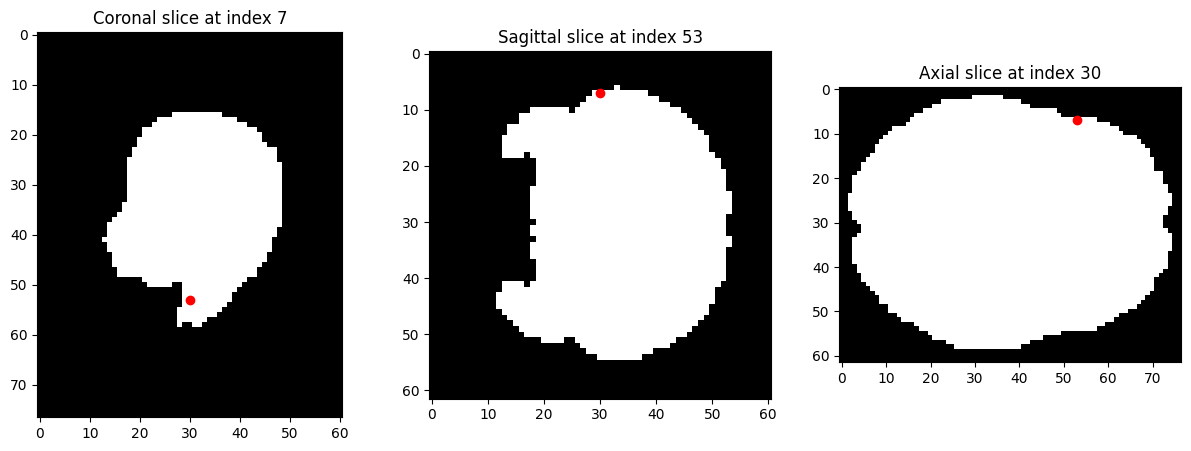

In [67]:
import matplotlib.pyplot as plt

# Plot the slice containing the voxel in each view

# Coronal slice (along the first axis)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_data[coords[0], :, :], cmap='gray')
plt.title(f'Coronal slice at index {coords[0]}')
plt.scatter(coords[2], coords[1], color='red')  # Mark the voxel position

# Sagittal slice (along the second axis)
plt.subplot(1, 3, 2)
plt.imshow(image_data[:, coords[1], :], cmap='gray')
plt.title(f'Sagittal slice at index {coords[1]}')
plt.scatter(coords[2], coords[0], color='red')  # Mark the voxel position

# Axial slice (along the third axis)
plt.subplot(1, 3, 3)
plt.imshow(image_data[:, :, coords[2]], cmap='gray')
plt.title(f'Axial slice at index {coords[2]}')
plt.scatter(coords[1], coords[0], color='red')  # Mark the voxel position

plt.show()

In [2]:
import nibabel as nib
import numpy as np

# Load the NIfTI file
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_LLaVA-OV_32f_last_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")


The largest value in the NIfTI file is: 0.3747795931189196


In [3]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_LLaVA-OV_32f_mid_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.3762868974640624


In [4]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_ResNet-50_32f_last_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.33337482724435147


In [7]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_ResNet-50_32f_mid_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.16168535764955366


In [8]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_ViViT_32f_last_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.2312013889608709


In [6]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_ViViT_32f_mid_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.2702145884443161


In [12]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_BLIP_32f_last_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.20856803804718194


In [13]:
file_path = '/scratch/qy775/nma/results/test/llm_rdm/group10_RSA_BetasAvg_llm-RDM_BLIP_32f_mid_task-test_wb.nii'
nii_image = nib.load(file_path)

# Get the image data as a numpy array
image_data = nii_image.get_fdata()

# Find the largest value in the image data
largest_value = np.max(image_data)

print(f"The largest value in the NIfTI file is: {largest_value}")

The largest value in the NIfTI file is: 0.21275080205540392
